# Object quantification on a single image

---
*notebook based on the material for the "Introduction to Image Analysis" Workshop*

*Stefania Marcotti (stefania.marcotti@crick.ac.uk)*

*CC-BY-SA-4.0 license: creativecommons.org/licenses/by-sa/4.0/*

---

In this notebook, we will illustrate a simple workflow, consisting of a number of steps, designed to accomplish the goal of **quantifying intensity and morphology of objects in a microscopy image**. 

You will learn how to:

* Open images
* Use filters to suppress noise
* Segment images using grey level thresholding
* Segment images using seeded watershedding  
* Perform intensity and morphological quantifications

### Import libraries

Python is organised in modules and packages. To make them available in our current notebook, we use the keyword `import`. We can also import specific functions by using the syntax [`from` module `import` function]. Additionally, we can define aliases for module names with the keyword `as`.

You can check the documentation for the various modules if you want to know more!

* [`os`](https://docs.python.org/3/library/os.html) - miscellaneous operating system interfaces
* [`numpy`](https://numpy.org/) and [`scipy`](https://scipy.org/) - scientific computing
* [`scikit_image`](https://scikit-image.org/docs/stable/api/skimage.html) (a.k.a. [`skimage`](https://scikit-image.org/docs/stable/api/skimage.html)) - image processing and computer vision
* [`matplotlib`](https://matplotlib.org/) - visualisations
* [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) - data managing

In [1]:
import os

import numpy as np
from scipy import ndimage

from skimage import io
from skimage import filters
from skimage import measure
from skimage import segmentation
from skimage import morphology

import matplotlib.pyplot as plt

import pandas as pd

### Open images

To get started with our quantification task, the first thing we need to do is open an image. We will use as example image [`003003-10.tif`](https://github.com/FrancisCrickInstitute/from-notebook-to-pipeline/blob/main/Data/idr0028/003003-10.tif), where some cells have been stained for *nuclei (Hoescht, ch0)*, *tubulin (AlexaFluor568, ch1)*, *actin (AlexaFluor488, ch2)*, and *YAP/TAZ (AlexaFluor647, ch3)* and imaged with fluorescent microscopy. You can find more information about this [public image dataset](https://idr.openmicroscopy.org/webclient/?show=plate-5679) in [the associated publication](https://www.nature.com/articles/sdata201718).

Next, we will display our example image to screen - it's always good practice to get an idea about the kind of data we're working with! We will be working with various channels, so we will need to make sure to select the correct ones.

In [2]:
# read .tif file
im_read = io.imread('../Data/idr0028/003003-10.tif')

In [7]:
# define spatial resolution (x,y)
spatial_resolution = (0.6549,0.6549)

In [3]:
# print image type
print('Image type:', type(im_read))

Image type: <class 'numpy.ndarray'>


In [4]:
# print image dimensions
print('Image dimensions:', im_read.shape)

Image dimensions: (501, 667, 4)


The image dimensions are currently in the (y, x, c) format. Ideally, by convention, we would want the dimensions of the image to be (c, y, x). We can rearrange the dimensions by using the numpy function [`transpose`](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html).

In [5]:
# rearrange channels
im = np.transpose(im_read, (2, 0, 1))
print('New image dimensions:', im.shape)

New image dimensions: (4, 501, 667)


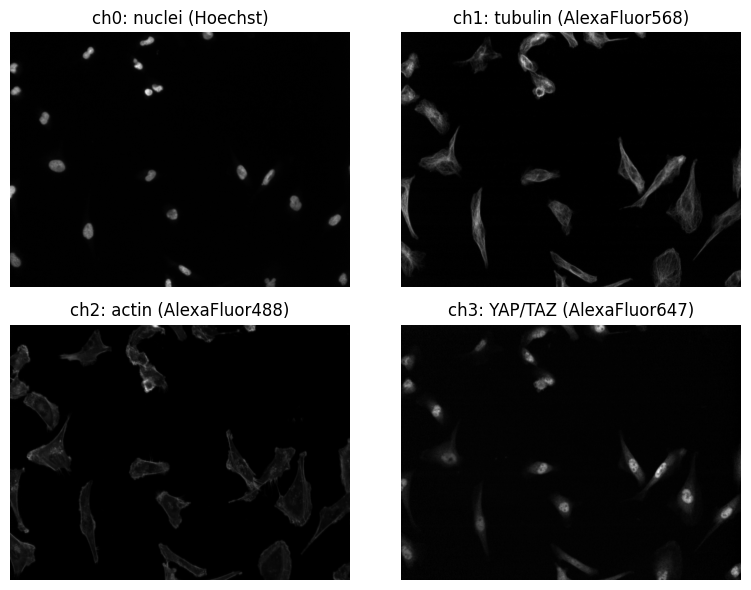

In [6]:
# display all channels 
fig, axs = plt.subplots(2, 2, figsize=(8,6))

axs[0, 0].imshow(im[0,], cmap='gray')
axs[0, 0].set_title('ch0: nuclei (Hoechst)')
axs[0, 0].axis('off')

axs[0, 1].imshow(im[1,], cmap='gray')
axs[0, 1].set_title('ch1: tubulin (AlexaFluor568)')
axs[0, 1].axis('off')

axs[1, 0].imshow(im[2,], cmap='gray')
axs[1, 0].set_title('ch2: actin (AlexaFluor488)')
axs[1, 0].axis('off')

axs[1, 1].imshow(im[3,], cmap='gray')
axs[1, 1].set_title('ch3: YAP/TAZ (AlexaFluor647)')
axs[1, 1].axis('off')

plt.tight_layout()

### Analyse the image to obtain object properties

We are going to work with 3 of the image channels, in particular the nuclei (ch0), the tubulin (ch1), as a proxy for the cell, and the YAP/TAZ (ch3). The aim of the pipeline is to obtain information about each cell area and the intensity distribution of a marker (YAP/TAZ) in the nucleus and cytoplasm of each cell.

In [8]:
# select and rename channels
nuclei = im[0,]
cytoplasm = im[1,]
YAP = im[3,]

First, we are going to work on the nuclear channel:
* Filter to suppress the noise
* Threshold to obtain a binary mask, where the foreground is separated from the background (semantic segmentation)
* Label the binary mask to assign a unique ID to each object (instance segmentation)

You can read more about thresholding [in this guide](https://bioimagebook.github.io/chapters/2-processing/3-thresholding/thresholding.html).

In [9]:
# nuclei: Gaussian filter
nuclei_gauss = filters.gaussian(nuclei, sigma=2)
# nuclei: threshold with Otsu to obtain binary mask
threshold_nuclei = filters.threshold_otsu(nuclei_gauss)
nuclei_threshold = nuclei_gauss >= threshold_nuclei
# nuclei: label mask
nuclei_labels = measure.label(nuclei_threshold)

Next, we are going to look at the tubulin channel, which can be used as a proxy for the cell, as the tubulin tends to be distributed relatively evenly across the cell surface:
* Filter to suppress noise
* Threshold to obtain a binary mask
* Label the binary mask using an algorithm called seeded watershed to obtain matching labels to the nuclear ones

You can read more about seeded watershed [at this page](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/segmentation_2d_membranes.html).

In [10]:
# cells: filter with Gaussian
cell_gauss = filters.gaussian(cytoplasm, sigma=2)
# cells: threshold with Otsu to obtain binary mask
threshold_cell = filters.threshold_otsu(cell_gauss)
cell_threshold = cell_gauss >= threshold_cell
# cells: fill holes in binary mask
cell_threshold = ndimage.binary_fill_holes(cell_threshold)
# cells: label mask (seeded watershed)
cell_labels = segmentation.watershed(cell_gauss, markers=nuclei_labels, mask=cell_threshold, compactness=2)
cell_labels = segmentation.clear_border(cell_labels)

We now have two label masks, one for the nuclei and one for the cells. We want to make sure that the same objects are available in both and that no nuclei are missing their respective cell/cytoplasm. This sometimes happens when the nucleus of a cell is fully inside the image, while its cytoplasm spills out of the image border. To achieve this, we can filter the nuclei label mask to ignore all nuclei with an ID that is not available in the cell label mask. 

In [11]:
# nuclei: clean mask to keep only cells where the cytoplasm was detected
boolean_mask = np.isin(nuclei_labels, np.unique(cell_labels))
nuclei_labels_clean = np.zeros_like(nuclei_labels)
nuclei_labels_clean[boolean_mask] = nuclei_labels[boolean_mask]

If we want to obtain an intensity ratio between the nucleus and the cytoplasm, we need to make sure that the cell label mask does not contain the region pertinent to the nucleus itself. We can therefore subtract the two masks to achieve this aim.

In [12]:
# cytoplasm: obtain mask from subtracting nuclei from cells labels
cytoplasm_labels = cell_labels - nuclei_labels_clean
cytoplasm_labels[cytoplasm_labels<0]=0

Let's take a look at what we have so far!

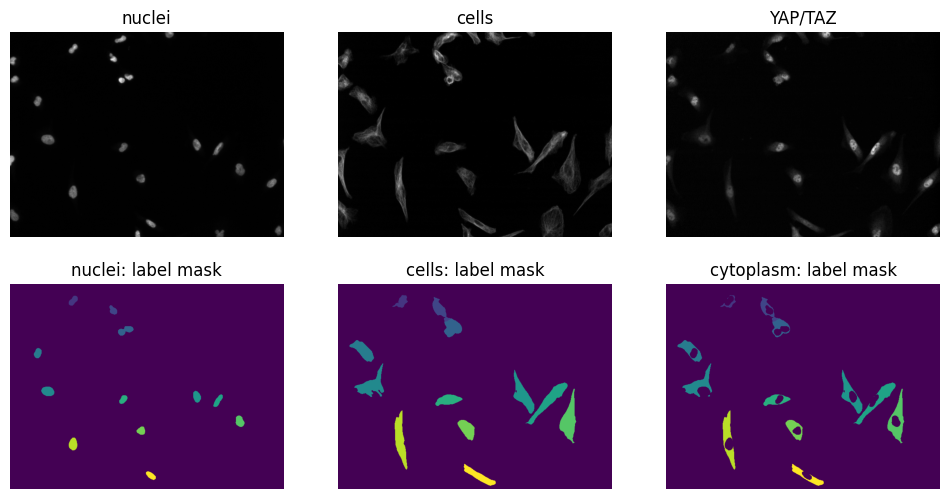

In [13]:
# display images and labels 
fig, axs = plt.subplots(2, 3, figsize=(12,6))

axs[0,0].imshow(nuclei, cmap='gray')
axs[0,0].set_title('nuclei')
axs[0,0].axis('off')

axs[0,1].imshow(cytoplasm, cmap='gray')
axs[0,1].set_title('cells')
axs[0,1].axis('off')

axs[0,2].imshow(YAP, cmap='gray')
axs[0,2].set_title('YAP/TAZ')
axs[0,2].axis('off')

axs[1,0].imshow(nuclei_labels_clean)
axs[1,0].set_title('nuclei: label mask')
axs[1,0].axis('off')

axs[1,1].imshow(cell_labels)
axs[1,1].set_title('cells: label mask')
axs[1,1].axis('off')

axs[1,2].imshow(cytoplasm_labels)
axs[1,2].set_title('cytoplasm: label mask')
axs[1,2].axis('off')

plt.show()

We are now ready to perform some quantifications. In particular, for each object, we want to analyse:
* the cell area
* the ratio between the YAP/TAZ signal in the nucleus vs. the cytoplasm

In [14]:
# quantify each object
props_cell_area = pd.DataFrame(measure.regionprops_table(cell_labels, properties=['area', 'label'], spacing=spatial_resolution))
props_nuclei_YAP = pd.DataFrame(measure.regionprops_table(nuclei_labels_clean, YAP, properties=['intensity_mean', 'label']))
props_nuclei_YAP.columns = ['intensity_mean_YAP_nuclei', 'label']
props_cytoplasm_YAP = pd.DataFrame(measure.regionprops_table(cytoplasm_labels, YAP, properties=['intensity_mean', 'label']))
props_cytoplasm_YAP.columns = ['intensity_mean_YAP_cytoplasm', 'label']
# merge into a single dataframe
props_df = props_cell_area.merge(props_nuclei_YAP, on='label', how='outer')
props_df = props_df.merge(props_cytoplasm_YAP, on='label', how='outer')
# adjust column names
props_df = props_df[['label', 'area', 'intensity_mean_YAP_nuclei', 'intensity_mean_YAP_cytoplasm']]
props_df.columns = ['Object_label', 'Cell_area_um2', 'YAP_mean_intensity_nuclei', 'YAP_mean_intensity_cytoplasm']
# calculate YAP/TAZ ratio
props_df['YAP_mean_intensity_ratio'] = props_df['YAP_mean_intensity_nuclei'] / props_df['YAP_mean_intensity_cytoplasm']
# add image ID 
props_df['image_ID'] = '003003-10.tif'

In [15]:
props_df

,Object_label,Cell_area_um2,YAP_mean_intensity_nuclei,YAP_mean_intensity_cytoplasm,YAP_mean_intensity_ratio,image_ID
0,3,249.616314,82.718935,30.275093,2.732244,003003-10.tif
1,4,460.632167,166.993266,30.697555,5.439953,003003-10.tif
2,6,579.435808,168.620952,49.348668,3.416930,003003-10.tif
3,8,643.769909,190.025788,38.465278,4.940190,003003-10.tif
4,9,930.700002,90.184300,33.410944,2.699244,003003-10.tif
5,10,895.530693,218.912195,49.369487,4.434160,003003-10.tif
6,11,1004.469771,245.818681,52.752400,4.659858,003003-10.tif
7,12,506.094932,189.911565,54.690745,3.472463,003003-10.tif
8,14,1110.835486,218.600000,45.066355,4.850625,003003-10.tif
9,15,552.844379,182.761905,47.398357,3.855870,003003-10.tif


### Further reading
If you're interested in knowing more about image analysis in Python, there are a lot of free resources out there! One good starting point is the [IAFIG-RMS Python for Bioimage Analysis Course](https://github.com/RMS-DAIM/Python-for-Bioimage-Analysis). Good luck with your image analysis adventures!